# Imports

In [1]:
# Python standard library
import sys

# Scientific computing
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy.ndimage

# Program specific
sys.path.append('/home/prestonh/Desktop/Research/pore_stats/pore_stats/oi/')
import optical_imaging as oi
import oi_file


# Jupyter
from IPython.display import HTML

# Load data

In [2]:
date = '7-7-2017/'
particle = '293-T/'
channel = '17p5-35-17p5_0/'
file_index = '0'

base_path = '/home/prestonh/Desktop/Research/cancer_cells/data/'

oi_vid_file_path = base_path + date + particle + channel + 'oi/bin/test_camera_' + file_index
oi_events_file_path = base_path + date + particle + channel + 'oi/events/test_camera_' + file_index + '_events.json'

In [3]:
# Load video
oi_vid = oi_file.Video(oi_vid_file_path, 512, 288, 100000)

# Load events
oi_events = oi_file.open_event_file_json(oi_events_file_path)

/home/prestonh/Desktop/Research/pore_stats/pore_stats/oi/optical_imaging.py:62: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if pixels != None:


# Load template and create stage

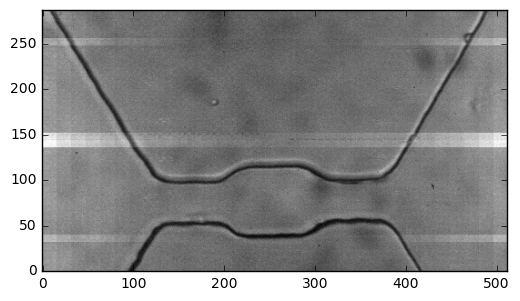

In [4]:
template_index = 0

template_frame = oi_vid.get_frame(template_index)

plt.imshow(template_frame, cmap = 'gray', origin = 'lower')
plt.show()

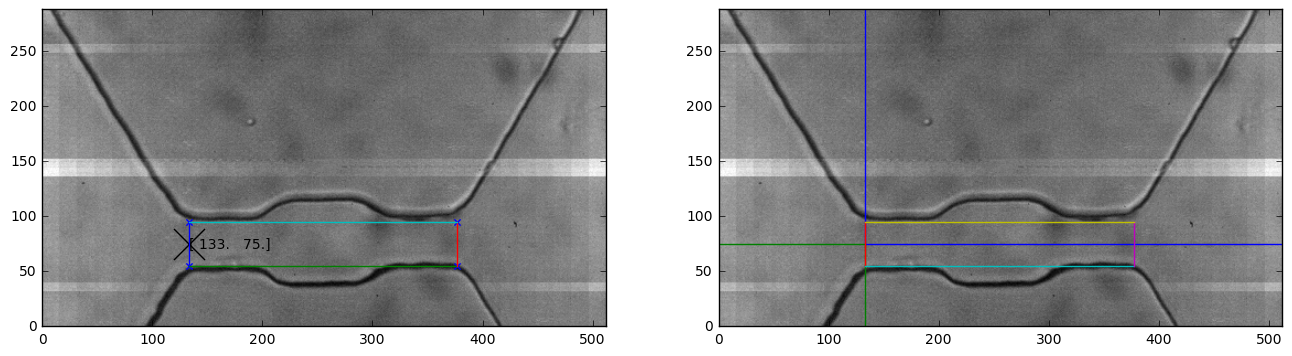

In [5]:
reload(oi)
template_index = 0
template_frame = oi_vid.get_frame(template_index)
c0 = [133, 95]
c1 = [133, 55]
c2 = [377, 55] 
c3 = [377, 95]
oi_stage = oi.Stage(template_frame, c0, c1, c2, c3)
oi_stage.plot_stage()

# Find a good event

In [6]:
oi_index = 3
reload(oi_file)
plt.close()
HTML(oi_file.make_animation(oi_vid, oi_events[oi_index]._detections[0]._tf, oi_events[oi_index]._detections[-1]._tf).to_html5_video())

# Plotting functions

In [15]:
def plot_frame(frame, show = True):
    plt.imshow(frame, cmap = 'gray', origin = 'lower', interpolation = 'none')
    
    if show:
        plt.show()
    
def plot_processed_over_raw(processed_frame, frame, show = True):
    green_processed_frame = np.zeros((processed_frame.shape[0], processed_frame.shape[1], 3))
    green_processed_frame[:,:,1] = processed_frame

    plt.imshow(frame, cmap = 'gray', origin = 'lower', alpha = 1, interpolation = 'none')
    plt.imshow(green_processed_frame, cmap = 'gray', origin = 'lower', alpha = 0.15, interpolation = 'none')

    if show:
        plt.show()
    
def plot_frame_hist(frame, show = True):
    plt.hist(frame.flatten(), facecolor = 'k', bins = 100)
    
    if show:
        plt.show()
    
def plot_all(processed_frame, frame):
    fig, axes = plt.subplots(1,3,figsize = (12,3))
    
    # Plot 1
    plt.sca(axes[0])
    plot_frame(processed_frame, show = False)
    
    
    # Plot 2
    plt.sca(axes[1])
    plot_processed_over_raw(processed_frame, frame, show = False)
    
    # Plot 3
    plt.sca(axes[2])
    plot_frame_hist(processed_frame, show = False)
    
    plt.show()
    
    

# Inverted thresholding

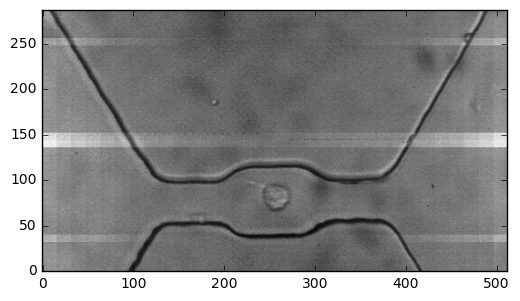

/home/prestonh/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


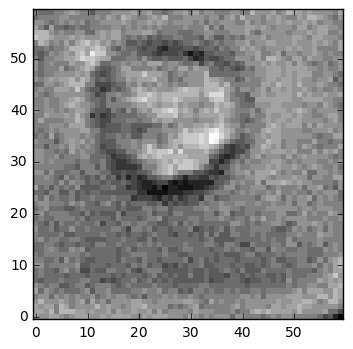

In [34]:
oi_event = oi_events[3]
detection = oi_event._detections[53]
raw_frame = oi_vid.get_frame(detection._tf)

plt.imshow(raw_frame, cmap = 'gray', origin = 'lower')
plt.show()

x0 = detection._px- 30
x1 = detection._px + 30
y0 = detection._py - 30
y1 = detection._py + 30
plt.imshow(raw_frame[y0:y1, x0:x1], cmap = 'gray', origin = 'lower', interpolation = 'none')
plt.show()

/home/prestonh/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


copy


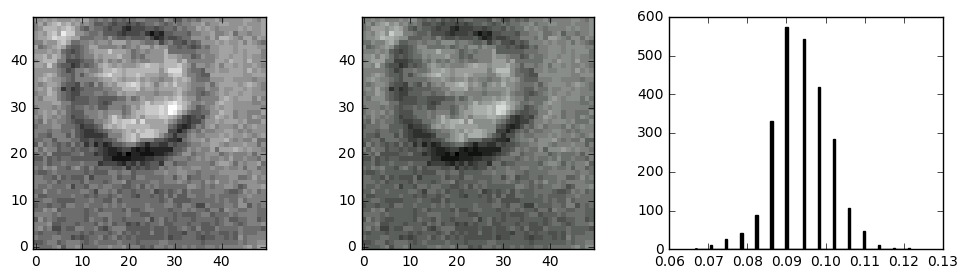

gaussian blur


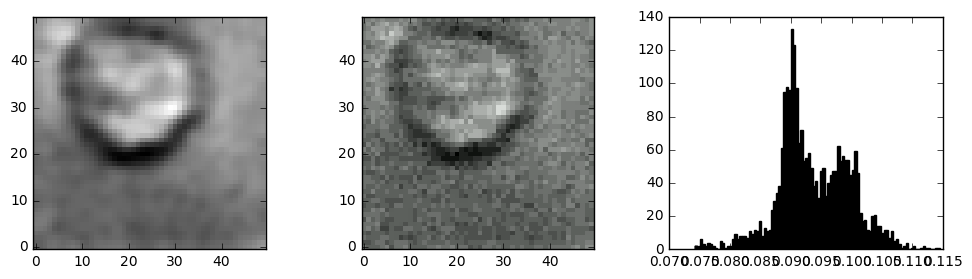

rescale


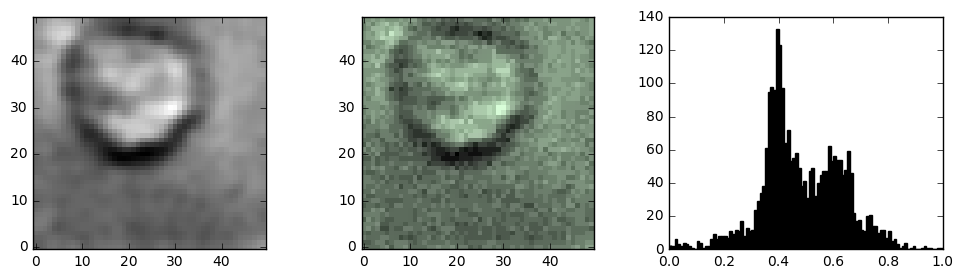

inverted threshold


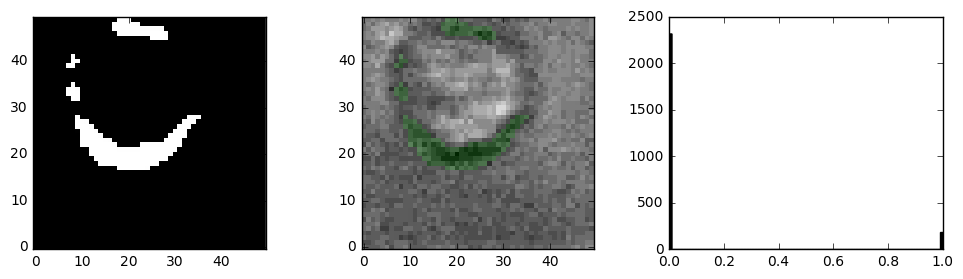

morphological closing


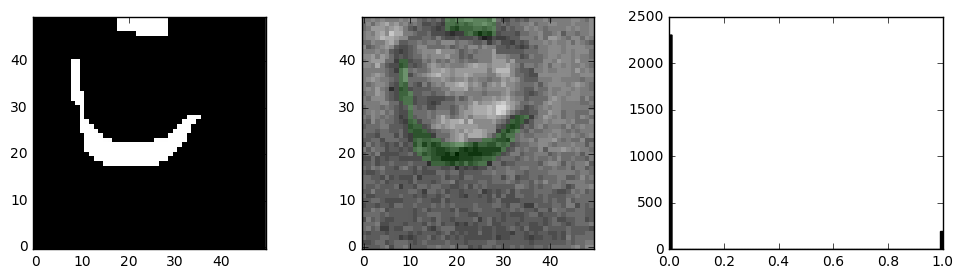

fitting ellipse


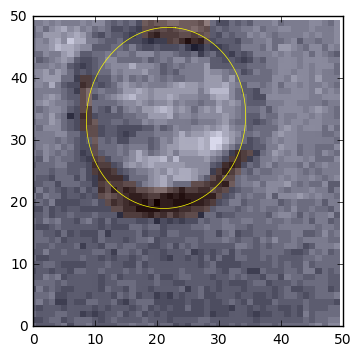

In [47]:
# Crop raw frame
x0 = detection._px - 25
x1 = detection._px + 25
y0 = detection._py - 25
y1 = detection._py + 25
frame = np.copy(raw_frame[y0:y1, x0:x1])

# Copy
print 'copy'
processed_frame = np.copy(frame)
plot_all(processed_frame, frame)

# Blur
print 'gaussian blur'
window = (5, 5)
processed_frame = cv2.GaussianBlur(processed_frame, window, 0)
plot_all(processed_frame, frame)

# Rescale
print 'rescale'
processed_frame = (processed_frame - np.min(processed_frame))/(np.max(processed_frame) - np.min(processed_frame))
plot_all(processed_frame, frame)


# Inverted threshold
print 'inverted threshold'
threshold = 0.3
above_indices = np.where(processed_frame > threshold)
below_indices = np.where(processed_frame <= threshold)

processed_frame[above_indices[0], above_indices[1]] = 0
processed_frame[below_indices[0], below_indices[1]] = 1

plot_all(processed_frame, frame)


# Morphological closing
print 'morphological closing'
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(10,10))
processed_frame = cv2.morphologyEx(np.array(processed_frame, dtype = np.uint8), cv2.MORPH_CLOSE, kernel)
plot_all(processed_frame, frame)


# Fit ellipse
print 'fitting ellipse'
cell_pixels = np.where(processed_frame == 1)

ellipse = oi.fit_ellipse(cell_pixels[0], cell_pixels[1])
ellipse_center = oi.get_ellipse_center(ellipse)
ellipse_angle = oi.get_ellipse_angle_of_rotation(ellipse)
ellipse_axes = oi.get_ellipse_axes_lengths(ellipse)



ellipse_points = np.empty((100,2))
for i in range(100):
    angle = i*2*np.pi/99.
    x = ellipse_axes[0]*np.cos(angle)
    y = ellipse_axes[1]*np.sin(angle)
    ellipse_points[i,1] = ellipse_center[0] + np.cos(ellipse_angle)*x - np.sin(ellipse_angle)*y
    ellipse_points[i,0] = ellipse_center[1] + np.sin(ellipse_angle)*x + np.cos(ellipse_angle)*y
    

plt.imshow(frame, cmap = 'gray', origin = 'lower', interpolation = 'none')
plt.imshow(processed_frame, alpha = 0.15, origin = 'lower', interpolation = 'none')
plt.plot(ellipse_points[:,0], ellipse_points[:,1], lw = 0.5, c = 'yellow')

plt.xlim(0, frame.shape[1])
plt.ylim(0, frame.shape[0])

plt.show()

# Negative thresholding

absolute value difference
copy


/home/prestonh/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


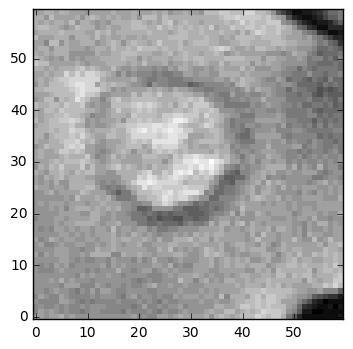

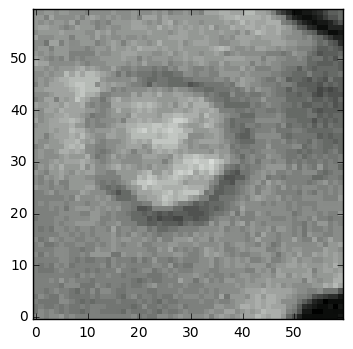

negative


/home/prestonh/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


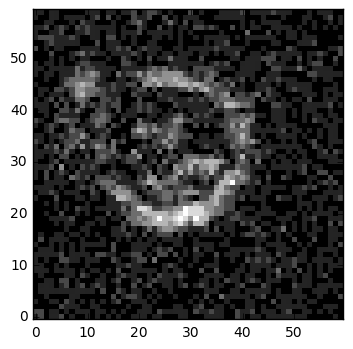

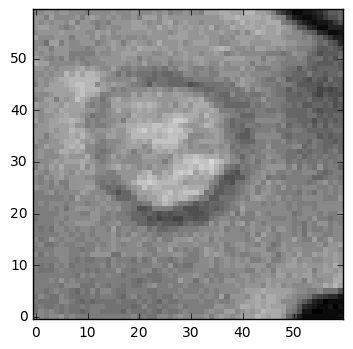

gaussian blur


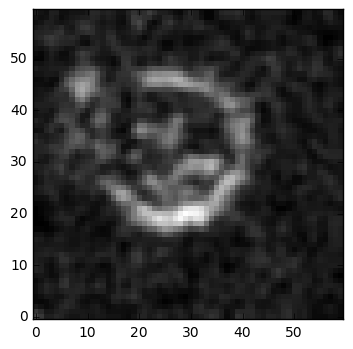

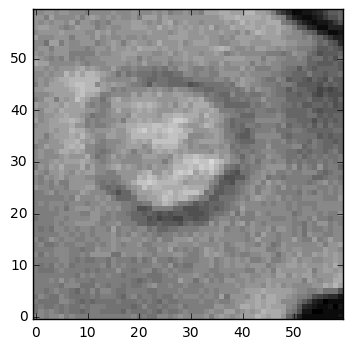

threshold


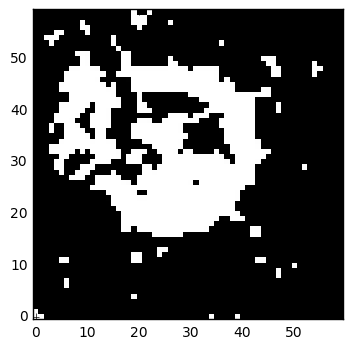

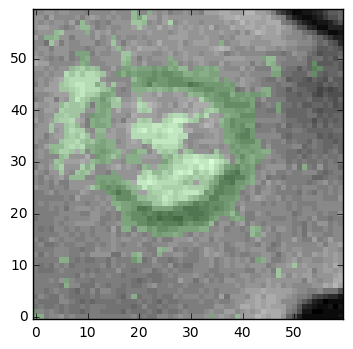

erode subtraction


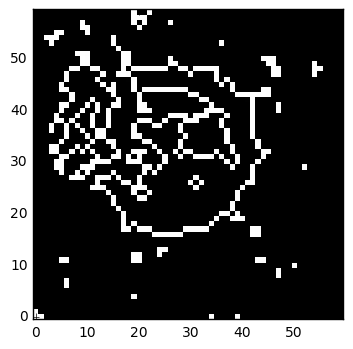

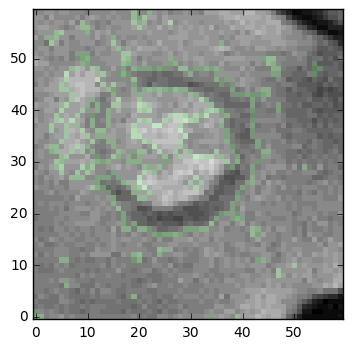

fill holes


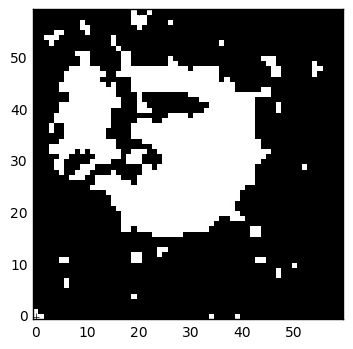

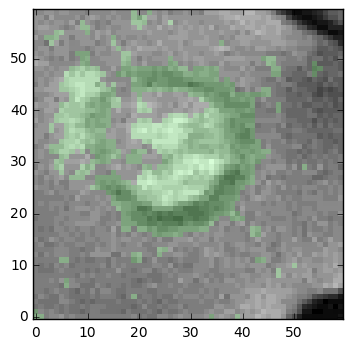

clustering


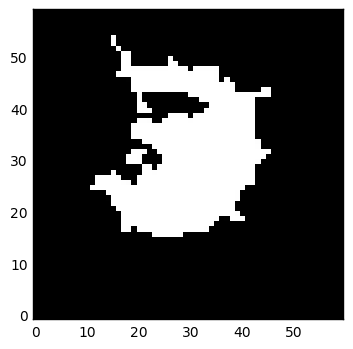

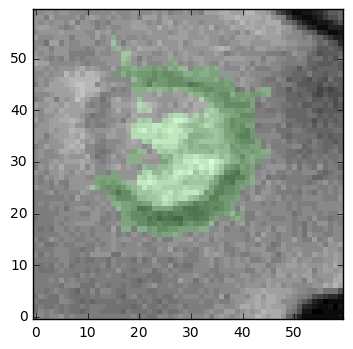

morphological closing


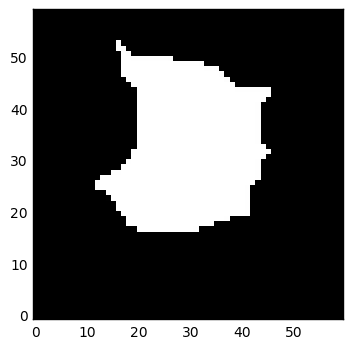

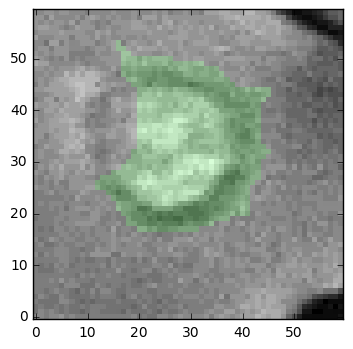

erode subtraction


/home/prestonh/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:78: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.


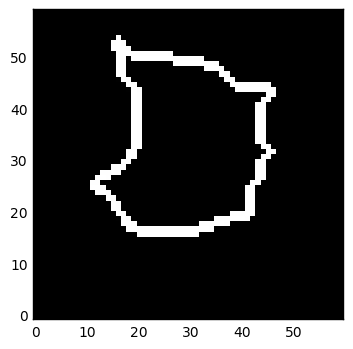

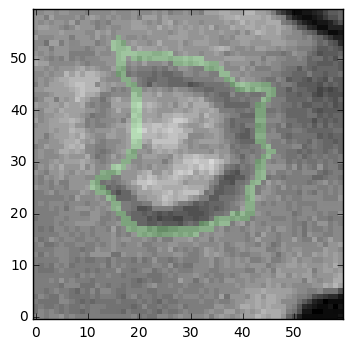

In [24]:
print 'absolute value difference'



# Crop raw frame
x0 = detection._px - 30
x1 = detection._px + 30
y0 = detection._py - 30
y1 = detection._py + 30
frame = raw_frame[y0:y1, x0:x1]

# Copy
print 'copy'
processed_frame = 1.*frame
plot_frame(processed_frame)
plot_processed_over_raw(processed_frame, frame)

# Negative
print 'negative'
processed_frame = np.abs(frame - template_frame[y0:y1, x0:x1])
plot_frame(processed_frame)
plot_processed_over_raw(processed_frame, frame)

# Blur
print 'gaussian blur'
window = (3,3)
processed_frame = cv2.GaussianBlur(processed_frame, window, 0)
plot_frame(processed_frame)
plot_processed_over_raw(processed_frame, frame)

# Threshold
print 'threshold'
threshold = .0045
processed_frame[processed_frame > threshold] = 1
processed_frame[processed_frame <= threshold] = 0
plot_frame(processed_frame)
plot_processed_over_raw(processed_frame, frame)





# Erode subtraction
print 'erode subtraction'
processed_frame = processed_frame - scipy.ndimage.morphology.binary_erosion(processed_frame, iterations = 1)
plot_frame(processed_frame)
plot_processed_over_raw(processed_frame, frame)

# Fill holes
print 'fill holes'
processed_frame = scipy.ndimage.binary_fill_holes(processed_frame)
plot_frame(processed_frame)
plot_processed_over_raw(processed_frame, frame)

# Get largest cluster
print 'clustering'
clusters = oi.find_clusters_percentage_based(processed_frame, np.zeros((processed_frame.shape[0], processed_frame.shape[1])), diag = True)
largest_cluster = sorted(clusters, key = lambda x: len(x))[-1]
processed_frame = np.zeros(processed_frame.shape, dtype = np.uint8)
for pixel in largest_cluster:
    processed_frame[pixel[0], pixel[1]] = 1
plot_frame(processed_frame)
plot_processed_over_raw(processed_frame, frame)



# Morphological closing
print 'morphological closing'
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(10,10))
processed_frame = cv2.morphologyEx(np.array(processed_frame, dtype = np.uint8), cv2.MORPH_CLOSE, kernel)
plot_frame(processed_frame)
plot_processed_over_raw(processed_frame, frame)



# Dilate/erode subtraction
print 'erode subtraction'
processed_frame = scipy.ndimage.morphology.binary_dilation(processed_frame, iterations = 1) - scipy.ndimage.morphology.binary_erosion(processed_frame, iterations = 1)
plot_frame(processed_frame)
plot_processed_over_raw(processed_frame, frame)

# All-frame processing

In [ ]:
def preprocess_frame(raw_frame, template_frame):
    



    # Crop raw frame
    x0 = detection._px - 30
    x1 = detection._px + 30
    y0 = detection._py - 30
    y1 = detection._py + 30

    frame = raw_frame[y0:y1, x0:x1]

    # Copy
    processed_frame = 1.*frame


    # Negative
    processed_frame = np.abs(frame - template_frame[y0:y1, x0:x1])

    # Blur
    window = (5,5)
    processed_frame = cv2.GaussianBlur(processed_frame, window, 0)

    # Threshold
    threshold = .005
    processed_frame[processed_frame > threshold] = 1
    processed_frame[processed_frame <= threshold] = 0


    # Erode subtraction
    processed_frame = processed_frame - scipy.ndimage.morphology.binary_erosion(processed_frame, iterations = 1)


    # Fill holes
    processed_frame = scipy.ndimage.binary_fill_holes(processed_frame)


    # Get largest cluster
    clusters = oi.find_clusters_percentage_based(processed_frame, np.zeros((processed_frame.shape[0], processed_frame.shape[1])), diag = True)
    largest_cluster = sorted(clusters, key = lambda x: len(x))[-1]
    processed_frame = np.zeros(processed_frame.shape, dtype = np.uint8)
    for pixel in largest_cluster:
        processed_frame[pixel[0], pixel[1]] = 1




    # Morphological closing
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(10,10))
    processed_frame = cv2.morphologyEx(np.array(processed_frame, dtype = np.uint8), cv2.MORPH_CLOSE, kernel)




    # Dilate/erode subtraction
    processed_frame = scipy.ndimage.morphology.binary_dilation(processed_frame, iterations = 1) - scipy.ndimage.morphology.binary_erosion(processed_frame, iterations = 1)

    plot_processed_over_raw(processed_frame, frame, x0, x1, y0, y1)

In [ ]:
oi_event = oi_events[3]

oi_event.get_channel_enter_exit_tf(oi_stage)

for i in range(oi_event._channel_enter_tf, oi_event._channel_exit_tf + 1):
    detection = oi_event._detections[i - oi_event._detections[0]._tf]
    raw_frame = oi_vid.get_frame(detection._tf)
    
    preprocess_frame(raw_frame, template_frame)

In [ ]:
# Fit ellipse
print 'ellipse fit'
xs, ys = np.where(processed_frame == 1)
ellipse = oi.fit_ellipse(xs, ys)

ellipse_center = oi.get_ellipse_center(ellipse)
ellipse_angle = oi.get_ellipse_angle_of_rotation(ellipse)
ellipse_axes_lengths = oi.get_ellipse_axes_lengths(ellipse)

num_points = 100
ellipse_edge_pixels = np.empty((num_points,2))
for i in range(num_points):
    theta = (1.*i)/num_points * 2.*np.pi
    x = ellipse_axes_lengths[0]*np.cos(theta)
    y = ellipse_axes_lengths[1]*np.sin(theta)
    ellipse_edge_pixels[i,0] = ellipse_center[0] + np.cos(ellipse_angle)*x - np.sin(ellipse_angle)*y
    ellipse_edge_pixels[i,1] = ellipse_center[1] + np.sin(ellipse_angle)*x + np.cos(ellipse_angle)*y
    
